<a href="https://colab.research.google.com/github/GMAvaliani/intern/blob/main/nnUnet_%D0%B7%D0%B0%D0%BF%D1%83%D1%81%D0%BA_%D0%B2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
from collections import OrderedDict

In [ ]:
import json
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch

In [ ]:
assert torch.cuda.is_available() # если не подключено, нажми: Runtime-Change runtime type- выбери GPU

In [ ]:
!pip install SimpleITK==2.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.8 MB/s eta 0:00:00


In [ ]:
!pip install nnunetv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.2/149.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 63.6 MB/s eta 0:00:00
  Created wheel for nnunetv2: filename=nnunetv2-2.1-py3-none-any.whl siz

In [ ]:
import nnunetv2

In [ ]:
# connecting to Google Colab
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

drive_dir = "/content/drive/MyDrive"
mount_dir = os.path.join(drive_dir, "Colab Notebooks")
base_dir = os.getcwd()

Mounted at /content/drive


In [ ]:
assert os.path.exists(drive_dir) # if this fails, something went wrong with mounting GoogleDrive
if os.path.exists(mount_dir) is False:
    os.makedirs(mount_dir)
print(mount_dir)

/content/drive/MyDrive/Colab Notebooks


In [ ]:
def make_if_dont_exist(folder_path,overwrite=False):
    """
    creates a folder if it does not exists
    input:
    folder_path : relative path of the folder which needs to be created
    over_write :(default: False) if True overwrite the existing folder
    """
    if os.path.exists(folder_path):

        if not overwrite:
            print(f"{folder_path} exists.")
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      os.makedirs(folder_path)
      print(f"{folder_path} created!")

In [ ]:
# Maybe move path of preprocessed data directly on content - this may be signifcantely faster!
print("Current Working Directory {}".format(os.getcwd()))
path_dict = {
    "nnUNet_raw" : os.path.join(mount_dir, "nnUNet_raw"),
    "nnUNet_preprocessed" : os.path.join(mount_dir, "nnUNet_preprocessed"), # 1 experiment: 1 epoch took 112s
    "nnUNet_results" : os.path.join(mount_dir, "nnUNet_results"),
    "RAW_DATA_PATH" : os.path.join(mount_dir, "RawData"), # This is used here only for convenience (not necessary for nnU-Net)!
}

# Write paths to environment variables
for env_var, path in path_dict.items():
  os.environ[env_var] = path

# Check whether all environment variables are set correct!
for env_var, path in path_dict.items():
  if os.getenv(env_var) != path:
    print("Error:")
    print("Environment Variable {} is not set correctly!".format(env_var))
    print("Should be {}".format(path))
    print("Variable is {}".format(os.getenv(env_var)))
  make_if_dont_exist(path, overwrite=False)

Current Working Directory /content
/content/drive/MyDrive/Colab Notebooks/nnUNet_raw exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet_preprocessed exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet_results exists.
/content/drive/MyDrive/Colab Notebooks/RawData exists.
If No Error Occured Continue Forward. =)


In [ ]:
dataset_name = 'Dataset005_xLung'
nnunet_raw_data = os.path.join(os.getenv("nnUNet_raw"))
# nnunet_raw_data = "nnUNet/nnunet/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name = os.path.join(nnunet_raw_data,dataset_name)
train_image_dir = os.path.join(task_folder_name,'imagesTr')
train_label_dir = os.path.join(task_folder_name,'labelsTr')
test_dir = os.path.join(task_folder_name,'imagesTs')
# main_dir = os.path.join(base_dir,'nnUNet/nnunet')

# Create Folder Structure for the SCGM Task on the system
make_if_dont_exist(task_folder_name)
make_if_dont_exist(train_image_dir)
make_if_dont_exist(train_label_dir)
make_if_dont_exist(test_dir)

training_data_name="training-data-Dataset005_xLung"
test_data_name="test-data-Dataset005_xLung"

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset005_xLung exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset005_xLung/imagesTr exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset005_xLung/labelsTr exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset005_xLung/imagesTs exists.


In [ ]:
if os.path.isfile(os.path.join(task_folder_name, training_data_name+'.zip')) is False:
  print("Please download the dataset zipfiles and place them into the following directory: \n {}".format(task_folder_name))
else:
  print(f'Training file exists')

Please download the dataset zipfiles and place them into the following directory: 
 /content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset005_xLung


In [ ]:

# verify that files are in the correct place!
os.chdir(task_folder_name)
!ls
if os.path.isfile(training_data_name+'.zip'):
    print(f'Training file exists')
else:
    print('Training file is not present in the directory')
    print("Please check whether {}.zip is in Folder {}".format(training_data_name, task_folder_name))

# Testing Data is sadly Currently not available
# if os.path.isfile(test_data_name+'.zip'):
#     print('Testing file exists')
# else:
#     print('Testing file is not present in the directory')
#     print("Please check whether {}.zip is in Folder {}".format(test_data_name, task_folder_name))
os.chdir(base_dir)
print("We are currently in working directory {}".format(os.getcwd()))

dataset.json  imagesTr	imagesTs  labelsTr
Training file is not present in the directory
Please check whether training-data-Dataset005_xLung.zip is in Folder /content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset005_xLung
We are currently in working directory /content


## **Data Preprocessing**

In [ ]:
# function for copying, savind and renaming
def copy_and_rename(old_location,old_file_name,new_location,new_filename,delete_original = False):

    shutil.copy(os.path.join(old_location,old_file_name),new_location)
    os.rename(os.path.join(new_location,old_file_name),os.path.join(new_location,new_filename))
    if delete_original:
        os.remove(os.path.join(old_location,old_file_name))

# putting training images into folder

mask_count = 4 # change if more mask is available
base_data_folder_name = os.path.join(task_folder_name)

for file in os.listdir(base_data_folder_name):
    # print(file)
    if file.endswith('.nii.gz'):
        if file.find('mask')!=-1:
            # putting mask
            shutil.move(os.path.join(base_data_folder_name,file),train_label_dir)
        else:
            # making 4 copies
            for mask in range(1,mask_count+1):
                new_filename = file[:file.find('-image')] + '-mask-r' + str(mask) + '.nii.gz'
                if mask==mask_count:
                    copy_and_rename(base_data_folder_name,file,train_image_dir,new_filename,delete_original = True)
                else:
                    copy_and_rename(base_data_folder_name,file,train_image_dir,new_filename)
    # removing all other files installed due to the unzip
    elif file.endswith('.txt'):
        os.remove(os.path.join(base_data_folder_name,file))

## **Verification of data**

In [ ]:

#renaming to add the modality
#images should be added with 0000
#can be skipped if modality is already mentioned
#re-write for multiple modalities

def check_modality(filename):
    """
    check for the existence of modality
    return False if modality is not found else True
    """
    end = filename.find('.nii.gz')
    modality = filename[end-4:end]
    for mod in modality:
        if not(ord(mod)>=48 and ord(mod)<=57): #if not in 0 to 9 digits
            return False
    return True

def rename_for_single_modality(directory):

    for file in os.listdir(directory):

        if check_modality(file)==False:
            new_name = file[:file.find('.nii.gz')]+"_0000.nii.gz"
            os.rename(os.path.join(directory,file),os.path.join(directory,new_name))
            print(f"Renamed to {new_name}")
        else:
            print(f"Modality present: {file}")

rename_for_single_modality(train_image_dir)

# again skip test due to non available data
# rename_for_single_modality(test_dir)

Modality present: lung_001_0000.nii.gz
Modality present: lung_003_0000.nii.gz
Modality present: lung_004_0000.nii.gz
Modality present: lung_005_0000.nii.gz
Modality present: lung_006_0000.nii.gz
Modality present: lung_009_0000.nii.gz
Modality present: lung_010_0000.nii.gz
Modality present: lung_014_0000.nii.gz
Modality present: lung_015_0000.nii.gz
Modality present: lung_016_0000.nii.gz


In [ ]:
# Этот код создает или перезаписывает файл dataset.json в папке task_folder_name, который описывает мой набор данных

overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = dataset_name
    json_dict['description'] = "Lung and cancer segmentation"
    json_dict['tensorImageSize'] = "3D"
    json_dict['reference'] = "see challenge website"
    json_dict['licence'] = "see challenge website"
    json_dict['release'] = "0.0"

    #you may mention more than one modality
    json_dict['channel_names'] = {
        "0": "CT"
    }

    # set expected file ending
    json_dict["file_ending"] = ".nii.gz"

    #label names should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "background": 0,
        "cancer": 1,
    }

    train_ids = os.listdir(train_label_dir)
    test_ids = os.listdir(test_dir)
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)


    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=True)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else:
            print('dataset.json overwritten!')
json_file_path = os.path.join(task_folder_name, 'dataset.json')
print('Путь к файлу dataset.json:', json_file_path)

dataset.json already exist!
dataset.json overwritten!
Путь к файлу dataset.json: /content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset005_xLung/dataset.json


## **Dataset Preprocessing**

In [ ]:
!nnUNetv2_plan_and_preprocess -d 005 --verify_dataset_integrity

Fingerprint extraction...
Dataset005_xLung
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Experiment planning...
Attempting to find 3d_lowres config. 
Current spacing: [1.28234411 0.82279285 0.82279285]. 
Current patch size: [ 96 160 160]. 
Current median shape: [268.93203883 497.08737864 497.08737864]
Attempting to find 3d_lowres config. 
Current spacing: [1.32081443 0.84747663 0.84747663]. 
Current patch size: [ 96 160 160]. 
Current median shape: [261.09906683 482.60910548 482.60910548]
Attempting to find 3d_lowres config. 
Current spacing: [1.36043887 0.87290093 0.87290093]. 
Current patch size: [ 96 160 160]. 
Current median shape: [253.49423964 468.55252959 468.55252959]
Attempting to find 3d_lowres config. 
Current spacing: [1.40125203 0.89908796 0.89908796]. 
Current patch size: [ 96 160 160]

## **Dataset Visualization**

(512, 512, 5) (512, 512, 5)


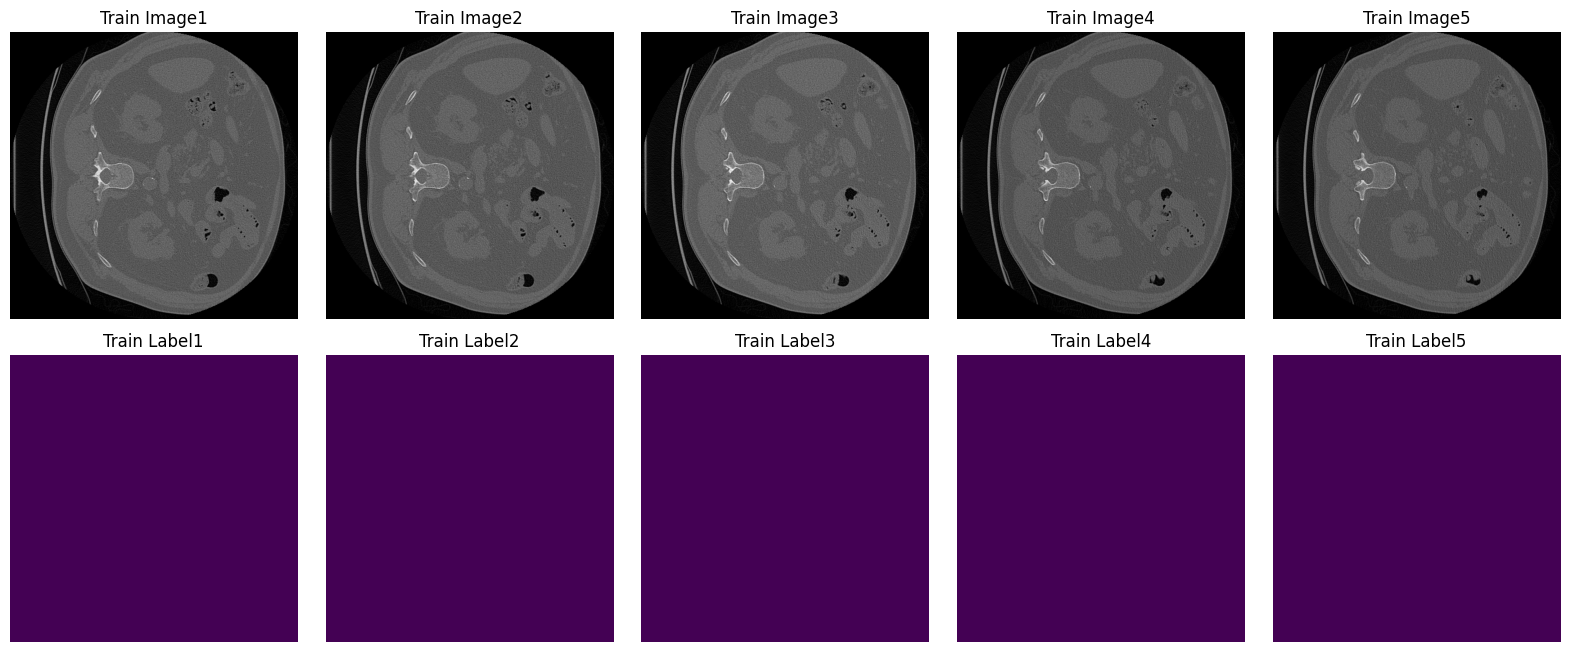

In [ ]:

#visualizing some of the training images and labels
# (re-run to see random pick-ups)
# only maximum of first 5 slices are plotted
train_img_name = os.listdir(train_image_dir)[np.random.randint(0,10)]
train_img = np.array(nib.load(os.path.join(train_image_dir,train_img_name)).dataobj)[:,:,:5]
train_label_name = train_img_name[:train_img_name.find('_0000.nii.gz')]+'.nii.gz'
train_label = np.array(nib.load(os.path.join(train_label_dir,train_label_name)).dataobj)[:,:,:5]

print(train_img.shape,train_label.shape)

max_rows = 2
max_cols = train_img.shape[2]

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))
for idx in range(max_cols):
    axes[0, idx].axis("off")
    axes[0, idx].set_title('Train Image'+str(idx+1))
    axes[0 ,idx].imshow(train_img[:,:,idx], cmap="gray")
for idx in range(max_cols):
    axes[1, idx].axis("off")
    axes[1, idx].set_title('Train Label'+str(idx+1))
    axes[1, idx].imshow(train_label[:,:,idx])

plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

In [ ]:
!nnUNetv2_train 005 3d_fullres 0 -tr nnUNetTrainer_1epoch

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################


This is the configuration used by this training:
Configuration name: 3d_fullres
 {'data_identifier': 'nnUNetPlans_3d_fullres', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 2, 'patch_size': [96, 160, 160], 'median_image_size_in_voxels': [277.0, 512.0, 512.0], 'spacing': [1.2449942827224731, 0.7988280057907104, 0.7988280057907104], 'normalization_schemes': ['CTNormalization'], 'use_mask_for_norm': [False], 'UNet_class_name': 'PlainConvUNet', 'UNet_base_num_features': 32, 'n_conv_per_stage_encoder': [2, 2, 2, 2, 2, 2], 'n_conv_per_stage_decoder': [2, 2, 2, 2,

In [ ]:
!nnUNetv2_plan_and_preprocess -d 005 -c 3d_fullres --verify_dataset_integrity

Fingerprint extraction...
Dataset005_xLung
Traceback (most recent call last):
  File "/usr/local/bin/nnUNetv2_plan_and_preprocess", line 8, in <module>
    sys.exit(plan_and_preprocess_entry())
  File "/usr/local/lib/python3.10/dist-packages/nnunetv2/experiment_planning/plan_and_preprocess_entrypoints.py", line 173, in plan_and_preprocess_entry
    extract_fingerprints(args.d, args.fpe, args.npfp, args.verify_dataset_integrity, args.clean, args.verbose)
  File "/usr/local/lib/python3.10/dist-packages/nnunetv2/experiment_planning/plan_and_preprocess_api.py", line 46, in extract_fingerprints
    extract_fingerprint_dataset(d, fingerprint_extractor_class, num_processes, check_dataset_integrity, clean,
  File "/usr/local/lib/python3.10/dist-packages/nnunetv2/experiment_planning/plan_and_preprocess_api.py", line 29, in extract_fingerprint_dataset
    verify_dataset_integrity(join(nnUNet_raw, dataset_name), num_processes)
  File "/usr/local/lib/python3.10/dist-packages/nnunetv2/experiment_pl

In [ ]:

# train nnU-Net with 3d_fullres model on the SCGM Task with Fold 0
# Again Training may take a while therefore it is advised to interrupt the training after some time (e.g. after 1 epoch)
# 1 Epoch takes approximately: over 30 minutes on GoogleColab -- you need GoogleColab Pro to run this completely
!nnUNetv2_train 501 3d_fullres 0 -tr nnUNetTrainer_1epoch

In [ ]:

# Optional
!nnUNetv2_find_best_configuration -d 501

In [ ]:

result_dir = os.path.join(os.getenv("RESULTS_FOLDER"),'nnUNet_Prediction_Results',dataset_name)
make_if_dont_exist(result_dir)

team_name = 'awesome_nnU-Net_team' #make sure to change for your own team name

In [ ]:
#location where you want save your results, will be created if dont exist
!nnUNet_predict -i '${nnUNet_raw_data_base}/nnUNet_raw_data/Task101_SCGM/imagesTs' -o '${RESULTS_FOLDER}/Task101_SCGM/predTs' -d 501 -tr nnUNetTrainer_1epoch -c 3d_fullres


In [ ]:
#visualizing the predicted results
# (re-run to see random pick-ups)
# only maximum of first 5 slices are plotted

test_img_name = os.listdir(test_dir)[np.random.randint(0,40)]
test_img = np.array(nib.load(os.path.join(test_dir,test_img_name)).dataobj)[:,:,:5]
predicted_img_name = test_img_name[:test_img_name.find('_0000.nii.gz')]+'.nii.gz'
predicted_label = np.array(nib.load(os.path.join(result_dir,predicted_img_name)).dataobj)[:,:,:5]
print('Test Image Shape: ',test_img.shape)
print("Predicted Image Shape:",predicted_label.shape)

max_rows = 2
max_cols = test_img.shape[2]

fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,8))
for idx in range(max_cols):
    axes[0, idx].axis("off")
    axes[0, idx].set_title('Test Image'+str(idx+1))
    axes[0 ,idx].imshow(test_img[:,:,idx], cmap="gray")
for idx in range(max_cols):
    axes[1, idx].axis("off")
    axes[1, idx].set_title('Predicted Label'+str(idx+1))
    axes[1, idx].imshow(predicted_label[:,:,idx])

plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

# **КОНЕЦ**